In [1]:
import numpy as np
import re
import pandas as pd
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
driver = webdriver.Chrome('chromedriver.exe')
url = 'https://www.imdb.com/title/tt5074352/reviews?ref_=tt_urv'
time.sleep(1)
driver.get(url)
time.sleep(1)

In [3]:
sel = Selector(text = driver.page_source)
review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
more_review_pages = int(int(review_counts)/25)

In [4]:
for i in tqdm(range(more_review_pages)):
    try:
        css_selector = 'load-more-trigger'
        driver.find_element(By.ID, css_selector).click()
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


In [5]:
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')
first_review = reviews[0]
sel2 = Selector(text = first_review.get_attribute('innerHTML'))
rating = sel2.css('.rating-other-user-rating span::text').extract_first().strip()

In [7]:
review_list = []
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

for d in tqdm(reviews):
    try:
        sel2 = Selector(text = d.get_attribute('innerHTML'))
        try:
            review = sel2.css('.text.show-more__control::text').extract_first()
        except:
            review = np.NaN
        review_list.append(review)
    except Exception as e:
        error_url_list.append(url)
        error_msg_list.append(e)
review_df = pd.DataFrame({
    'Review':review_list
    })

100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:06<00:00, 71.76it/s]


In [8]:
review_df.head()

,Review
0,Most of the reviewers for this film here on IM...
1,Let this incredibly sincere biopic wrestle wit...
2,I saw this with my family in a theatre. Awesom...
3,DANGAL is a masterpiece. A terrific film that ...
4,"""Direction was superb and Aamir's performance ..."


In [9]:
def cleanReview(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text)
    text = re.sub('#','',text)
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text

In [10]:
review_df['CleanedReview'] = review_df['Review'].apply(cleanReview)
review_df.head()

,Review,CleanedReview
0,Most of the reviewers for this film here on IM...,Most of the reviewers for this film here on IM...
1,Let this incredibly sincere biopic wrestle wit...,Let this incredibly sincere biopic wrestle wit...
2,I saw this with my family in a theatre. Awesom...,I saw this with my family in a theatre. Awesom...
3,DANGAL is a masterpiece. A terrific film that ...,DANGAL is a masterpiece. A terrific film that ...
4,"""Direction was superb and Aamir's performance ...","""Direction was superb and Aamir's performance ..."


In [11]:
review_df.to_csv('File.csv')

In [12]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
plt.style.use('fivethirtyeight')
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob
from wordcloud import WordCloud
from datetime import date

In [13]:
Clean_review = review_df[['CleanedReview']]
Clean_review

,CleanedReview
0,Most of the reviewers for this film here on IM...
1,Let this incredibly sincere biopic wrestle wit...
2,I saw this with my family in a theatre. Awesom...
3,DANGAL is a masterpiece. A terrific film that ...
4,"""Direction was superb and Aamir's performance ..."
...,...
461,The best Indian movie I've seen! The game of A...
462,"Very nice movie, must watch. Aamir Khan made a..."
463,This is a best movie of Aamir Khan. This will ...
464,"Good very nice Obviously lots of battles, but ..."


In [14]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [15]:
Clean_review['Subjectivity'] = Clean_review['CleanedReview'].apply(getSubjectivity)
Clean_review['Polarity'] = Clean_review['CleanedReview'].apply(getPolarity)

In [16]:
Clean_review.head()

,CleanedReview,Subjectivity,Polarity
0,Most of the reviewers for this film here on IM...,0.442188,0.170759
1,Let this incredibly sincere biopic wrestle wit...,0.789583,0.487153
2,I saw this with my family in a theatre. Awesom...,0.583333,0.488158
3,DANGAL is a masterpiece. A terrific film that ...,0.572121,0.123295
4,"""Direction was superb and Aamir's performance ...",0.850000,0.590000


In [17]:
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'

In [18]:
def getFactuality(score):
    if abs(score - 0) < 0.5:
        return "Factual"
    if abs(score - 1) < 0.5:
        return "Personal"

In [19]:
Clean_review['Rating'] = Clean_review['Polarity'].apply(getAnalysis)

In [20]:
Clean_review['Sentiment'] = Clean_review['Subjectivity'].apply(getFactuality)

In [21]:
Clean_review.head()

,CleanedReview,Subjectivity,Polarity,Rating,Sentiment
0,Most of the reviewers for this film here on IM...,0.442188,0.170759,Positive,Factual
1,Let this incredibly sincere biopic wrestle wit...,0.789583,0.487153,Positive,Personal
2,I saw this with my family in a theatre. Awesom...,0.583333,0.488158,Positive,Personal
3,DANGAL is a masterpiece. A terrific film that ...,0.572121,0.123295,Positive,Personal
4,"""Direction was superb and Aamir's performance ...",0.850000,0.590000,Positive,Personal


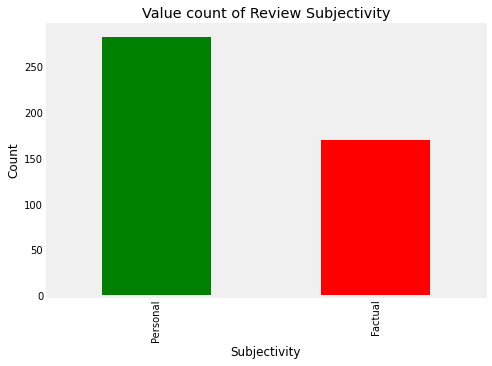

In [22]:
fig = plt.figure(figsize=(7,5))
color = ['green','red']
Clean_review['Sentiment'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of Review Subjectivity')
plt.ylabel('Count')
plt.xlabel('Subjectivity')
plt.grid(False)
plt.show()

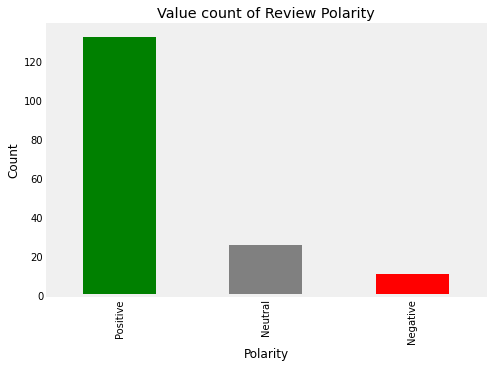

In [23]:
fig = plt.figure(figsize=(7,5))
color = ['green','grey','red']
Clean_review['Rating'][Clean_review['Sentiment']=='Factual'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of Review Polarity')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

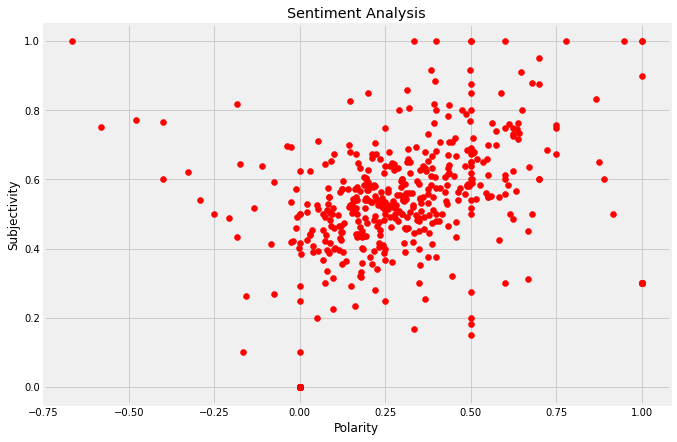

In [24]:
plt.figure(figsize=(10,7))
for i in range(0,Clean_review.shape[0]):
    plt.scatter(Clean_review['Polarity'][i],Clean_review['Subjectivity'][i], color='red')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [25]:
def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='white', 
                          width=800,
                          height=500, 
                          random_state=21,
                          max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

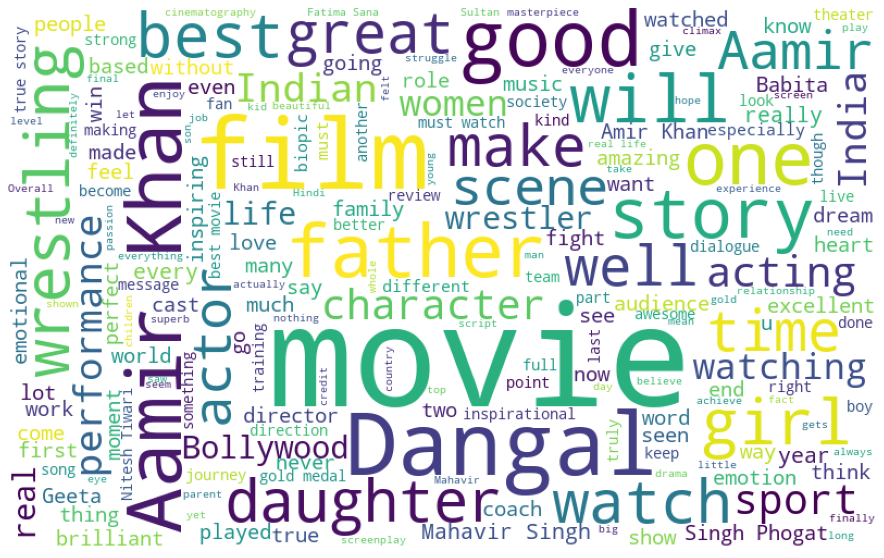

In [26]:
Positive_Review = Clean_review.loc[Clean_review['Rating']=='Positive','CleanedReview']
create_wordcloud(Positive_Review)

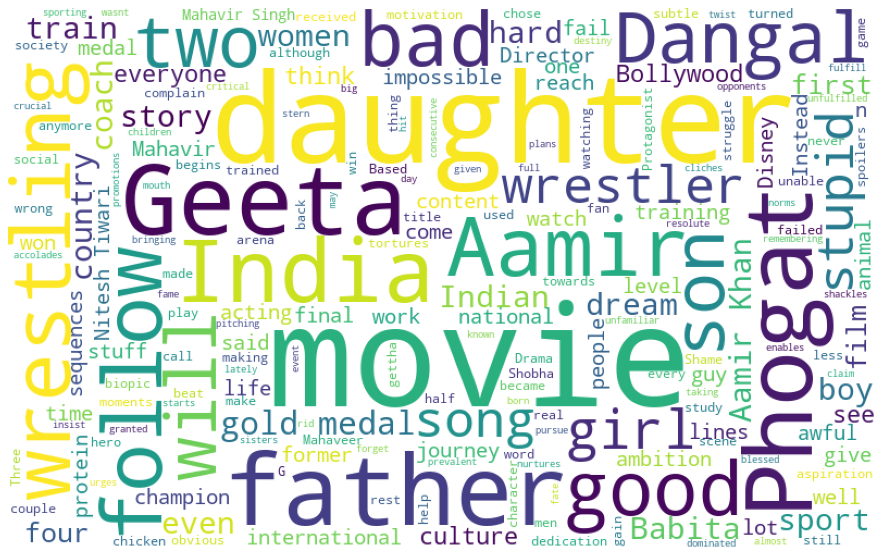

In [27]:
Negative_Review = Clean_review.loc[Clean_review['Rating']=='Negative','CleanedReview']
create_wordcloud(Negative_Review)

In [28]:
sentences = []
for word in Clean_review['CleanedReview']:
    sentences.append(word)
    
lines = list()
for line in sentences:
    words = line.split()
    for w in words:
        lines.append(w)
lines[:10]

['Most', 'of', 'the', 'reviewers', 'for', 'this', 'film', 'here', 'on', 'IMDb']

In [29]:
stemmer = SnowballStemmer(language='english')
stem=[]
for word in lines:
    stem.append(stemmer.stem(word))
stem[:20]

['most',
 'of',
 'the',
 'review',
 'for',
 'this',
 'film',
 'here',
 'on',
 'imdb',
 'appear',
 'to',
 'be',
 'folk',
 'of',
 'indian',
 'background;',
 'noth',
 'wrong',
 'with']

In [30]:
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

In [31]:
df = pd.DataFrame(stem2)
df=df[0].value_counts()
df

movi        564
film        226
aamir       225
watch       207
dangal      180
           ... 
effects,      1
music;        1
her?          1
ego?          1
content.      1
Name: 0, Length: 5158, dtype: int64

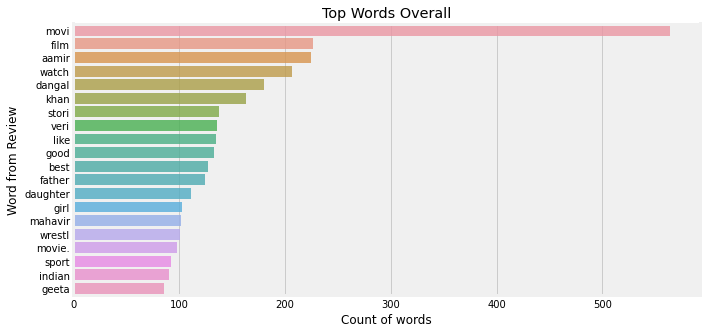

In [32]:
df = df[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overall')
plt.xlabel('Count of words', fontsize=12)
plt.ylabel('Word from Review', fontsize=12)
plt.show()